In [1]:
import os
import shutil
import random
import torch
import glob
import numpy as np
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19, VGG19_Weights
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import SubsetRandomSampler

In [2]:
!unzip -qq /content/santa.zip

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
train_normal_dir = "/content/train/normal"
train_santa_dir = "/content/train/santa"

In [5]:
normal_files = random.sample(os.listdir(train_normal_dir), 4)
santa_files = random.sample(os.listdir(train_santa_dir), 4)

normal_paths = [os.path.join(train_normal_dir, file) for file in normal_files]
santa_paths = [os.path.join(train_santa_dir, file) for file in santa_files]

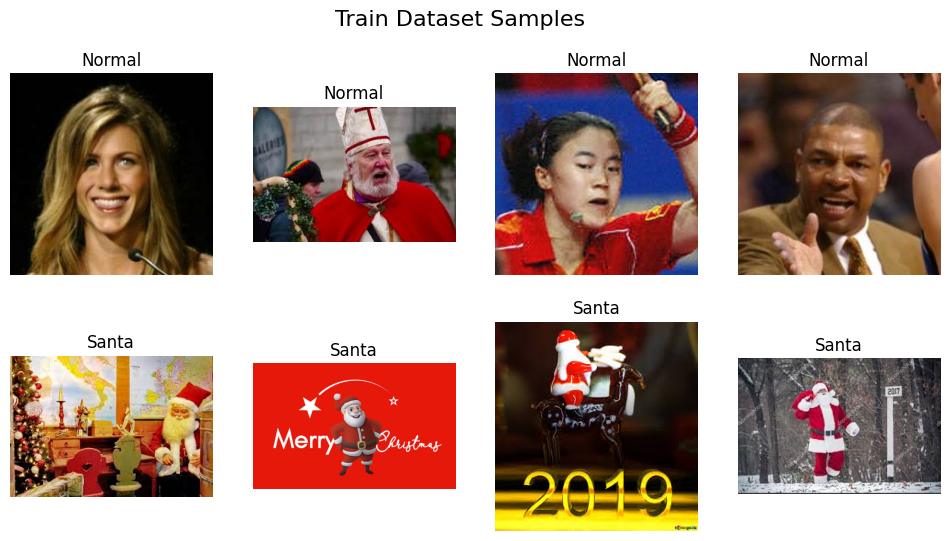

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Train Dataset Samples", fontsize=16)

for i, file_path in enumerate(normal_paths):
    image = Image.open(file_path)
    axes[0, i].imshow(image)
    axes[0, i].axis("off")
    axes[0, i].set_title("Normal")

for i, file_path in enumerate(santa_paths):
    image = Image.open(file_path)
    axes[1, i].imshow(image)
    axes[1, i].axis("off")
    axes[1, i].set_title("Santa")
plt.show()

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = ImageFolder('/content/train', transform=transform)
val_dataset = ImageFolder('/content/val', transform=transform)

print(len(train_dataset))
print(len(val_dataset))

895
267


In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [73]:
# for phase in ['train_loader', 'val_loader']:
#     imgs, labels = next(iter(dataloaders[phase]))
#     print(phase, imgs.shape, labels.shape)

KeyboardInterrupt: 

In [31]:
import torch.nn as nn

class vgg19(nn.Module):
    def __init__(self, num_classes=1000):
        super(vgg19, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # FC1
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),         # FC2
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),  # FC3
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x


In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
model = vgg19().to(device)

In [34]:
def train_model(optimizer_name, model, train_loader,val_loader,criterion,num_epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if optimizer_name =='SGD':
        # momentum : 가중치를 90%만 사용
        optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        # betas : Adam은 momentum의 평균값, 분산값을 튜플로 (평균 , 분산)으로 넣어준다.
        optimizer = optim.Adam(model.parameters(),lr=0.001, betas = (0.9,0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(model.parameters(),lr=0.001, betas = (0.9,0.999))
    else:
        raise ValueError(f'지원하지 않는 최적화 알고리즘: {optimizer_name}')

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 계산
        val_loss = 0.0
        model.eval()    # 모델을 평가모드로 설정
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        # flush : 강제로 출력 버퍼 줄여주는 것 -> 메모리 없애줌?
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%', flush =True)

    return train_losses, val_losses, val_accuracies

## SGD

In [35]:
train_losses_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', model, train_loader, val_loader, criterion)

Epoch [1/20], Train Loss: 6.8917, Val Loss: 6.8590, Val Accuracy: 49.81%


KeyboardInterrupt: 

In [25]:
model = vgg19().to(device)
# Adam
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', model, train_loader, val_loader, criterion)

Epoch [1/20], Train Loss: 2.1123, Val Loss: 0.6948, Val Accuracy: 50.19%
Epoch [2/20], Train Loss: 0.6940, Val Loss: 0.6896, Val Accuracy: 49.81%
Epoch [3/20], Train Loss: 0.6919, Val Loss: 0.6973, Val Accuracy: 50.19%
Epoch [4/20], Train Loss: 0.6955, Val Loss: 0.6942, Val Accuracy: 50.19%
Epoch [5/20], Train Loss: 0.6934, Val Loss: 0.6927, Val Accuracy: 49.81%
Epoch [6/20], Train Loss: 0.6934, Val Loss: 0.6917, Val Accuracy: 49.81%
Epoch [7/20], Train Loss: 0.6933, Val Loss: 0.6935, Val Accuracy: 50.19%
Epoch [8/20], Train Loss: 0.6934, Val Loss: 0.6928, Val Accuracy: 49.81%
Epoch [9/20], Train Loss: 0.6932, Val Loss: 0.6935, Val Accuracy: 50.19%
Epoch [10/20], Train Loss: 0.6937, Val Loss: 0.6936, Val Accuracy: 50.19%
Epoch [11/20], Train Loss: 0.6932, Val Loss: 0.6940, Val Accuracy: 50.19%
Epoch [12/20], Train Loss: 0.6932, Val Loss: 0.6941, Val Accuracy: 50.19%
Epoch [13/20], Train Loss: 0.6934, Val Loss: 0.6942, Val Accuracy: 50.19%
Epoch [14/20], Train Loss: 0.6930, Val Loss: 0.

In [26]:
model = vgg19().to(device)

# RAdam
train_losses_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', model, train_loader, val_loader, criterion)

Epoch [1/20], Train Loss: 0.6932, Val Loss: 0.6945, Val Accuracy: 50.19%
Epoch [2/20], Train Loss: 0.6936, Val Loss: 0.6942, Val Accuracy: 50.19%
Epoch [3/20], Train Loss: 0.6935, Val Loss: 0.6942, Val Accuracy: 50.19%
Epoch [4/20], Train Loss: 0.6934, Val Loss: 0.6941, Val Accuracy: 50.19%
Epoch [5/20], Train Loss: 0.6934, Val Loss: 0.6930, Val Accuracy: 49.81%
Epoch [6/20], Train Loss: 0.6934, Val Loss: 0.6938, Val Accuracy: 50.19%
Epoch [7/20], Train Loss: 0.6935, Val Loss: 0.6923, Val Accuracy: 49.81%
Epoch [8/20], Train Loss: 0.6938, Val Loss: 0.6922, Val Accuracy: 49.81%
Epoch [9/20], Train Loss: 0.6936, Val Loss: 0.6945, Val Accuracy: 50.19%
Epoch [10/20], Train Loss: 0.6933, Val Loss: 0.6941, Val Accuracy: 50.19%
Epoch [11/20], Train Loss: 0.6934, Val Loss: 0.6939, Val Accuracy: 50.19%
Epoch [12/20], Train Loss: 0.6933, Val Loss: 0.6920, Val Accuracy: 49.81%
Epoch [13/20], Train Loss: 0.6935, Val Loss: 0.6942, Val Accuracy: 50.19%
Epoch [14/20], Train Loss: 0.9255, Val Loss: 0.

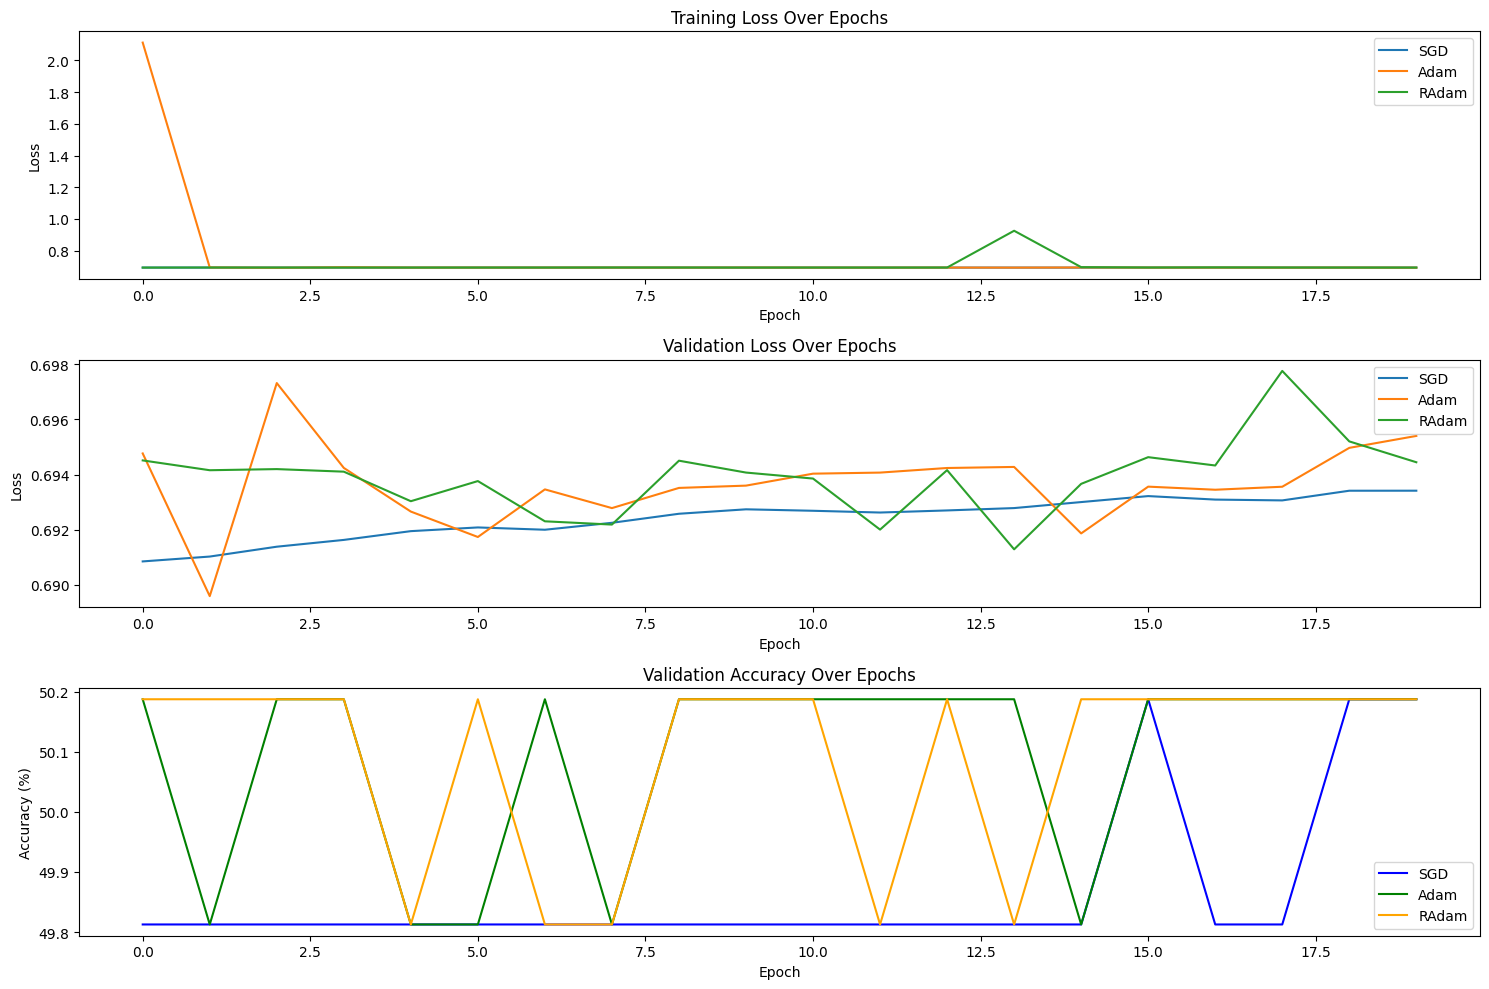

In [27]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_SGD, label='SGD')
plt.plot(val_losses_Adam, label='Adam')
plt.plot(val_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_SGD, label='SGD', color='blue')
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.plot(val_accuracies_RAdam, label='RAdam', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

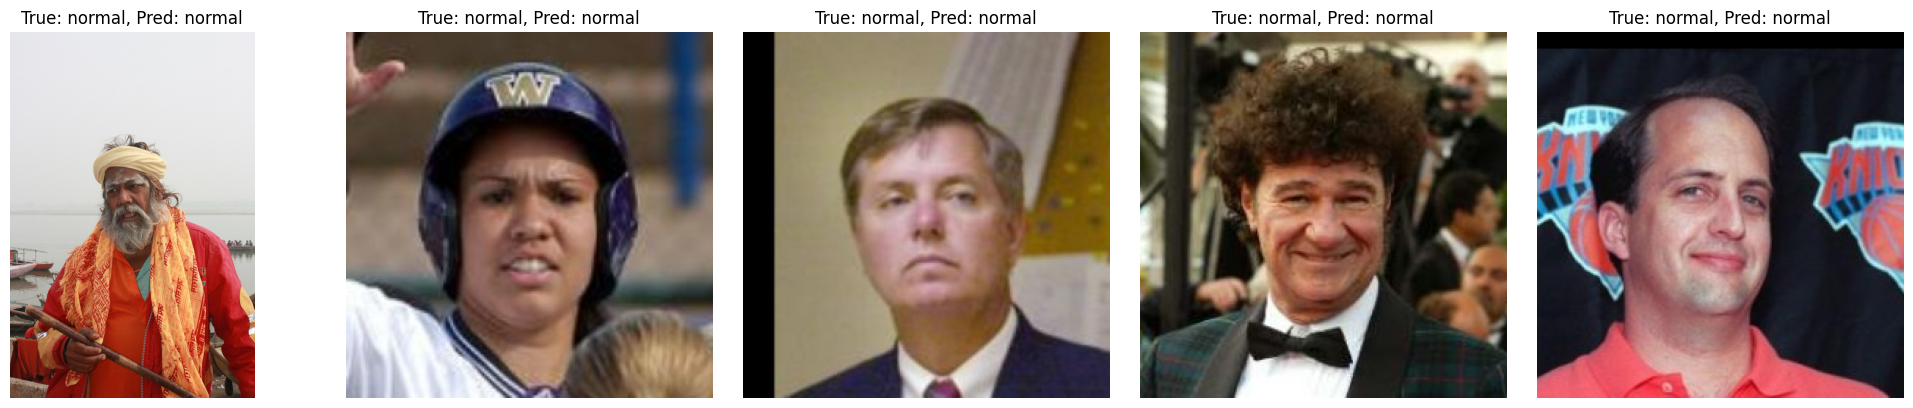

In [30]:
# 클래스별 폴더 경로
class_folders = {
    'normal': '/content/test/normal',
    'santa': '/content/test/senta'
}

# 디바이스 설정 (GPU 사용 가능 여부 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)

        image = image.to(device)

        model.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)

        prediction = 'normal' if predicted.item() == 0 else 'santa'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()